In [1]:
# Machine learning performance evaluation program.
# Input: "all_data.csv" (must be in the same directory).
# Algorithms: Naive Bayes, QDA, Random Forest, ID3, AdaBoost, MLP, Nearest Neighbors.
# Output: CSV report (algorithm metrics) and performance graphs.

In [2]:
from sklearn import metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import average_precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score, precision_score

import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import os
import pandas as pd
import csv
import time
import warnings
import math
warnings.filterwarnings("ignore")

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define base path for the Intrusion Detection System folder on Google Drive
base_path = "/content/drive/MyDrive/Intrusion Detection System/"

Mounted at /content/drive


In [4]:
# Define directories and file paths
result_file = os.path.join(base_path, "results", "results_Final.csv")
csv_file = os.path.join(base_path, "all_data.csv")
graph_folder = os.path.join(base_path, "results", "result_graph_Final")

def folder(f_name):
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print("The folder could not be created!")

# Create necessary folders if they don't exist
folder(os.path.join(base_path, "results"))
folder(graph_folder)

In [6]:
# Define the set of columns to be imported (20 features + Label)
usecols = ["Bwd Packet Length Std","Flow Bytes/s","Total Length of Fwd Packets","Fwd Packet Length Std",
           "Flow IAT Std","Flow IAT Min","Fwd IAT Total","Flow Duration","Bwd Packet Length Max",
           "Flow IAT Max","Flow IAT Mean","Total Length of Bwd Packets","Fwd Packet Length Min",
           "Bwd Packet Length Mean","Flow Packets/s","Fwd Packet Length Mean","Total Backward Packets",
           "Total Fwd Packets","Fwd Packet Length Max","Bwd Packet Length Min",'Label']

# Define ML algorithms
ml_list = {
    "Naive Bayes": GaussianNB(),
    "QDA": QDA(),
    "MLP": MLPClassifier(hidden_layer_sizes=(13,13,13), max_iter=500),
    "Random Forest": RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    "ID3": DecisionTreeClassifier(max_depth=5, criterion="entropy"),
    "AdaBoost": AdaBoostClassifier(),
    "Nearest Neighbors": KNeighborsClassifier(3)
}

# For algorithms other than Naive Bayes, QDA, and MLP, use the first 7 features defined in 'others'
others = ["Bwd Packet Length Std", "Flow Bytes/s", "Total Length of Fwd Packets", "Fwd Packet Length Std",
          "Flow IAT Std", "Flow IAT Min", "Fwd IAT Total"]

# Define the features to be used by each algorithm
algorithms_features = {
    "Naive Bayes": ['Bwd Packet Length Std', 'Total Length of Fwd Packets', 'Flow IAT Min',
                    'Fwd Packet Length Min', 'Flow Packets/s', 'Fwd Packet Length Mean'],
    "QDA": ['Bwd Packet Length Std', 'Flow Bytes/s', 'Total Length of Fwd Packets', 'Flow IAT Min'],
    "MLP": ['Bwd Packet Length Std', 'Flow Bytes/s', 'Total Length of Fwd Packets', 'Fwd Packet Length Std',
            'Flow IAT Min', 'Bwd Packet Length Max','Fwd Packet Length Min', 'Bwd Packet Length Mean',
            'Total Backward Packets', 'Total Fwd Packets', 'Fwd Packet Length Max', 'Bwd Packet Length Min'],
    # For these algorithms use the same feature set (the first 7 features)
    "Random Forest": others,
    "ID3": others,
    "AdaBoost": others,
    "Nearest Neighbors": others
}

In [7]:
seconds = time.time()  # Start overall timer
repetition = 10

In [8]:
# Create CSV file to save results
with open(result_file, "w", newline="", encoding="utf-8") as f:
    wrt = csv.writer(f)
    wrt.writerow(["File", "ML algorithm", "accuracy", "Precision", "Recall", "F1-score", "Time"])

# Dictionary to store aggregated F1 scores (list of values for each algorithm)
f1_results = {}

# Process each file (in this case, just "all_data.csv")
for j in [ "all_data.csv" ]:
    print('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' %
          ("File", "ML algorithm", "accuracy", "Precision", "Recall", "F1-score", "Time"))

    # Read the CSV file using the defined columns
    df = pd.read_csv(csv_file, usecols=usecols)
    df = df.fillna(0)

    # Convert labels: "BENIGN" becomes 1; all others become 0
    df["Label"] = df["Label"].apply(lambda x: 1 if x=="BENIGN" else 0)

    # Separate labels and features
    y = df["Label"]
    df.drop(columns=["Label"], inplace=True)

    # For each ML algorithm, perform cross-validation and store the results
    for algo in ml_list:
        # Select features for this algorithm
        X = df[algorithms_features[algo]]
        precision_list = []
        recall_list = []
        f1_list = []
        accuracy_list = []
        t_time_list = []

        for i in range(repetition):
            start = time.time()

            # Split data (80% train, 20% test)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=repetition)

            # Train and predict
            clf = ml_list[algo]
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_test)

            # Calculate metrics
            acc = clf.score(X_test, y_test)
            pr = precision_score(y_test, predictions, average='macro')
            rc = recall_score(y_test, predictions, average='macro')
            f_1 = f1_score(y_test, predictions, average='macro')

            precision_list.append(pr)
            recall_list.append(rc)
            f1_list.append(f_1)
            accuracy_list.append(acc)
            t_time_list.append(time.time() - start)

        # Print average results for the current algorithm
        print('%-17s %-17s  %-15s %-15s %-15s %-15s %-15s' %
              (j[0:-4], algo,
               str(round(np.mean(accuracy_list),2)),
               str(round(np.mean(precision_list),2)),
               str(round(np.mean(recall_list),2)),
               str(round(np.mean(f1_list),2)),
               str(round(np.mean(t_time_list),4))))

        # Append individual results to CSV
        with open(result_file, "a", newline="", encoding="utf-8") as f:
            wrt = csv.writer(f)
            for idx in range(repetition):
                wrt.writerow([j[0:-4], algo, accuracy_list[idx], precision_list[idx],
                              recall_list[idx], f1_list[idx], t_time_list[idx]])

        # Save the F1 scores for the bar chart
        f1_results[algo] = f1_list

        # (Optionally, if you wish to save individual box plots, you can comment the next two lines)
        # plt.boxplot(f1_list)
        # plt.title("All Dataset - " + str(algo)); plt.ylabel('F-measure'); plt.show()

File              ML algorithm       accuracy        Precision       Recall          F1-score        Time           
all_data          Naive Bayes        0.87            0.79            0.7             0.73            1.2587         
all_data          QDA                0.88            0.82            0.69            0.73            1.4804         
all_data          MLP                0.89            0.88            0.71            0.75            506.4604       
all_data          Random Forest      0.93            0.96            0.8             0.85            15.5549        
all_data          ID3                0.95            0.93            0.89            0.91            9.4688         
all_data          AdaBoost           0.93            0.91            0.83            0.86            110.2975       
all_data          Nearest Neighbors  0.97            0.94            0.94            0.94            202.8999       


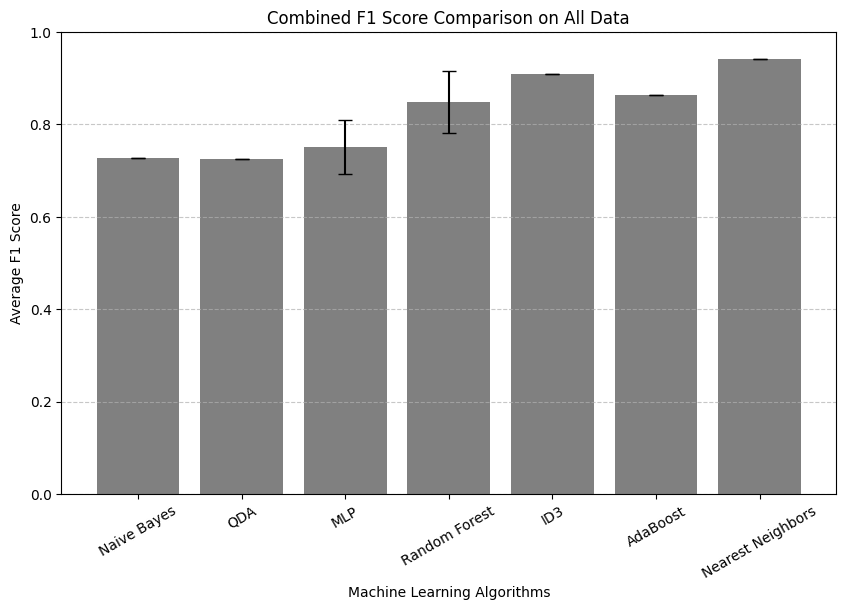

Total operation time: =  8515.945831537247 seconds


In [9]:
# After processing all algorithms, create a combined bar chart for F1 scores
ml_names = list(f1_results.keys())
f1_means = [np.mean(f1_results[m]) for m in ml_names]
f1_stds = [np.std(f1_results[m]) for m in ml_names]

plt.figure(figsize=(10,6))
plt.bar(ml_names, f1_means, yerr=f1_stds, color="gray", capsize=5)
plt.xlabel("Machine Learning Algorithms")
plt.ylabel("Average F1 Score")
plt.title("Combined F1 Score Comparison on All Data")
plt.xticks(rotation=30)
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(graph_folder, "Combined_F1_Comparison.pdf"), bbox_inches='tight', format='pdf')
plt.show()

print("Total operation time: = ", time.time()-seconds, "seconds")